In [3]:
import os
import yaml
import time
import torch
import epynet
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

from utils.epanet_loader import get_nx_graph
from utils.epanet_simulator import epanetSimulator
from utils.data_loader import battledimLoader, dataCleaner, dataGenerator, embedSignalOnGraph, rescaleSignal
from utils.helpers import discoverNeighbourhood, pipeByneighbourLookup, determineWindowSize
from modules.torch_gnn import ChebNet
from utils.visualisation import visualise

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress `FutureWarnings``

# Runtime configuration, paths, etc. 
path_to_wdn     = './data/L-TOWN.inp'     # Where is the EPANET .inp file stored?
path_to_data    = './data/l-town-data/'   # Where are the pressure measurement files stored
weight_mode     = 'pipe_length'           # How should the graph edges be weighted?
self_loops      = False                   # Should there be self loops on the observed nodes?
scaling         = 'minmax'                # How should the pressure measurements be scaled?
model_name      = 'l-town-chebnet-'   + weight_mode +'-' + scaling + '{}'.format('-self_loop' if self_loops else '')
last_model_path = './studies/models/' + model_name  + '-1.pt'
last_log_path   = './studies/logs/'   + model_name  + '-1.csv' 

# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode=weight_mode, get_head=True)

In [4]:
def read_prediction(filename='predictions.csv', scale=1, bias=0, start_date='2018-01-01 00:00:00'):
    df         = pd.read_csv(filename, index_col='Unnamed: 0')      # Read CSV
    df.columns = ['n{}'.format(int(node)+1) for node in df.columns] # Rename columns, 'n1', 'n2', ... 'n782'
    df         = df*scale+bias                                      # Rescale data to original interval of data given a scaling and bias factor
    df.index   = pd.date_range(start=start_date,                    # Set index as a Pandas datetime string
                               periods=len(df),
                               freq = '5min')
    return df

In [5]:
n_timesteps = 3                                              # Timesteps, t-1, t-2...t-n used to predict pressure at t
sample_rate = 5                                              # Minutes sampling rate of data
offset      = pd.DateOffset(minutes=sample_rate*n_timesteps) # We require n_timesteps of data for our first prediction

In [6]:
predictions = read_prediction(filename='./studies/results/pred_pressure_2018.csv',
                              scale   = 1,
                              bias    = 0,
                              start_date=pd.Timestamp('2018-01-01 00:00:00') + offset)

In [7]:
reconstructions = read_prediction(filename='./studies/results/recon_pressure_2018.csv',
                                  scale   = 1,
                                  bias    = 0,
                                  start_date=pd.Timestamp('2018-01-01 00:00:00'))             # <- Notice, no offset

In [8]:
leakages       = pd.read_csv('./data/l-town-data/2018_Leakages.csv',decimal=',',sep=';',index_col='Timestamp')
leakages.index = reconstructions.index # Fix the index column timestamp format

In [10]:
leakages       = pd.read_csv('./data/l-town-data/2018_Leakages.csv',decimal=',',sep=';',index_col='Timestamp')
leakages.index = reconstructions.index # Fix the index column timestamp format

In [11]:
nodal_estimation_error = (predictions-reconstructions).copy().dropna()

In [12]:
neighbours_by_pipe = {}

# For every node in the graph
for node in G:
    # We iterate through a dictionary of {neighbours : connecting_edges}
    for neighbour, connecting_edge in G[node].items():
        
        # If a connecting edge is pointing to the node under investigation, i.e. we encounter a self-loop
        if connecting_edge['name'] == 'SELF':    
            # We skip it
            continue    
            
        # Otherwise
        else:
            # We add an entry to our dictionary, with the name of the connecting edge, pointing to the names of the 
            # node under investigation and its neighbour
            neighbours_by_pipe[connecting_edge['name']] = [node, neighbour]

In [16]:
neighbours_by_pipe

{'p253': [347, 1],
 'p5': [3, 2],
 'p259': [352, 2],
 'p261': [353, 3],
 'p12': [9, 4],
 'p241': [8, 5],
 'p264': [355, 5],
 'p7': [9, 6],
 'p267': [357, 6],
 'p11': [10, 7],
 'p258': [351, 7],
 'p269': [358, 7],
 'p242': [11, 8],
 'p272': [360, 8],
 'p246': [344, 10],
 'p260': [352, 10],
 'p275': [362, 10],
 'p243': [13, 11],
 'p278': [364, 11],
 'p6': [14, 12],
 'p266': [356, 12],
 'p244': [17, 13],
 'p281': [366, 13],
 'p14': [16, 14],
 'p268': [357, 14],
 'p15': [16, 15],
 'p247': [344, 15],
 'p284': [368, 15],
 'p16': [18, 16],
 'p245': [21, 17],
 'p286': [369, 17],
 'p17': [20, 18],
 'p18': [24, 18],
 'p250': [345, 19],
 'p277': [363, 19],
 'p289': [371, 19],
 'p252': [23, 20],
 'p274': [361, 20],
 'p291': [372, 20],
 'p19': [25, 21],
 'p293': [373, 21],
 'p8': [30, 22],
 'p271': [359, 22],
 'p295': [374, 22],
 'p251': [31, 23],
 'p280': [365, 23],
 'p299': [377, 23],
 'p248': [346, 24],
 'p301': [378, 24],
 'p20': [28, 26],
 'p283': [367, 26],
 'p300': [377, 26],
 'p13': [31, 27

In [13]:
pipe_by_neighbours = { str(neighbour_list) : pipe for pipe , neighbour_list in neighbours_by_pipe.items()}

In [14]:
# Initialise an empty dictionary
edge_estimation_error = {}

# Iterate through the relationship dictionary items, the keys are the pipe names and the values are list of nodes
for pipe,nodes in neighbours_by_pipe.items():
    
    # Extract the node names in string format instead of integers
    node_1 = 'n' + str(nodes[0])
    node_2 = 'n' + str(nodes[1])
    
    # Add an entry to the dictionary, the key is the pipe name, and the value is the absolute difference 
    # of the columns 'node1' and 'node2' in our previous nodal_estimation_error DataFrame
    edge_estimation_error[pipe] = nodal_estimation_error[node_1] - nodal_estimation_error[node_2]
    
# Convert the dictionary of Pandas Series into a DataFrame
edge_estimation_error = pd.DataFrame(edge_estimation_error)

In [19]:
edge_estimation_error.head()

,p253,p5,p259,p261,p12,p241,p264,p7,p267,p11,...,p876,p879,p880,p881,p882,p883,p886,p887,p898,p901
2018-01-01 00:15:00,-0.017165,-0.011976,-0.004007,0.009509,-0.002516,-0.000062,0.001443,-0.003126,0.001811,-0.020762,...,-0.003408,0.001579,0.001011,0.001564,-0.000207,-0.000318,0.001275,0.000522,0.000121,-0.003912
2018-01-01 00:20:00,-0.017047,-0.011973,-0.004027,0.009506,-0.002441,0.000243,0.001377,-0.002978,0.002022,-0.020703,...,-0.003455,0.001537,0.000962,0.001200,0.000205,-0.000703,0.001059,0.000660,0.000073,-0.003295
2018-01-01 00:25:00,-0.017034,-0.012016,-0.004036,0.009487,-0.002562,0.000489,0.001288,-0.003009,0.002130,-0.020787,...,-0.003529,0.001572,0.001029,0.001388,-0.000070,-0.000407,0.001117,0.000644,0.000245,-0.003676
2018-01-01 00:30:00,-0.016973,-0.012053,-0.004082,0.009465,-0.002594,0.000777,0.001174,-0.003014,0.002291,-0.020824,...,-0.003465,0.001640,0.000981,0.001786,-0.000572,0.000004,0.001315,0.000458,0.000361,-0.003968
2018-01-01 00:35:00,-0.016897,-0.012055,-0.004106,0.009458,-0.002525,0.001014,0.001118,-0.002875,0.002439,-0.020791,...,-0.003345,0.001788,0.000906,0.001648,-0.000299,-0.000176,0.001458,0.000463,0.000071,-0.003403


<Axes: >

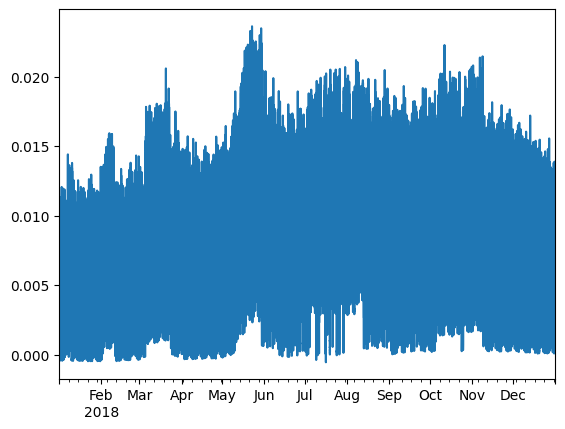

In [20]:
edge_estimation_error['p347'].plot()

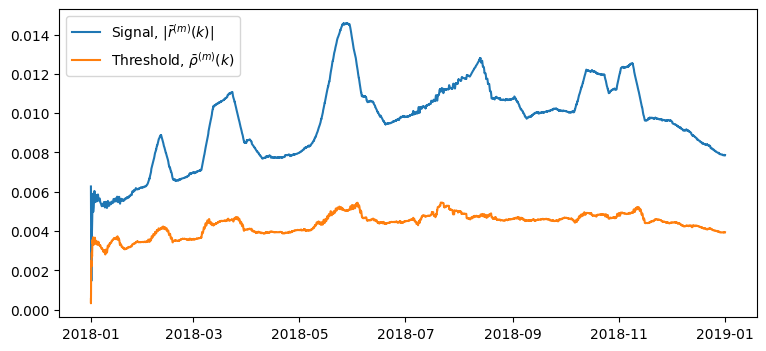

In [21]:
plt.figure(figsize=(9,4),dpi=100)
plt.plot(abs(edge_estimation_error['p347'].rolling('7d').mean()), label=r'Signal, $|\bar{r}^{(m)}(k)|$')
plt.plot(edge_estimation_error['p347'].rolling('7d').std(),       label=r'Threshold, $\bar{\rho}^{(m)}(k)$')
plt.legend()

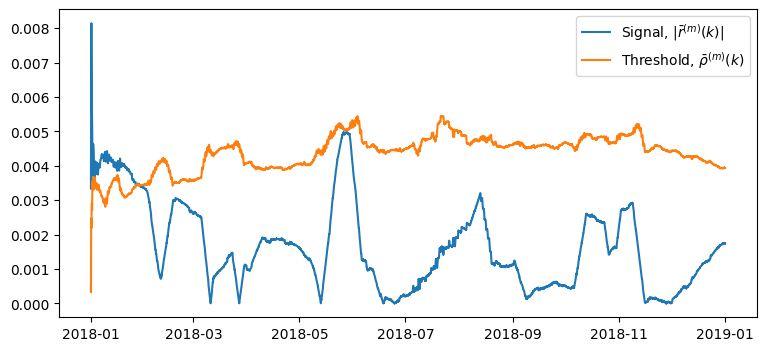

In [22]:
plt.figure(figsize=(9,4),dpi=100)
plt.plot(abs(edge_estimation_error['p347'].rolling('7d').mean()-edge_estimation_error['p347'].mean()), label=r'Signal, $|\bar{r}^{(m)}(k)|$')
plt.plot(edge_estimation_error['p347'].rolling('7d').std(),       label=r'Threshold, $\bar{\rho}^{(m)}(k)$')
plt.legend()


In [15]:
leak_timestamps = {}

for leak in leakages:
    leak_timestamps[leak] = leakages.index[leakages[leak]>0]

In [16]:
# k-hop neighbourhood of a leaky pipe - If a pipe is not within 6-hops from the leak source, it's considered to
# not have been affected by the leakage event
k = 6                                        

fault_times = {}

# First populate the key variable with empty lists, that are the k-hop neighbouring nodes of leaky pipes:
for leaky_pipe in leak_timestamps.keys():
    pipes, _ = discoverNeighbourhood(leaky_pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
    for pipe in pipes:
        fault_times[pipe] = []

In [17]:
for leaky_pipe, time in leak_timestamps.items():
    pipes, _ = discoverNeighbourhood(leaky_pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
    for pipe in pipes:
        fault_times[pipe].append(time)

In [18]:
pipe_with_most_faulty_periods = ''
most_faults_found_in_a_pipe   = 0

for pipe, dt_list in fault_times.items():
    n_faulty_periods = len(dt_list)
    
    if n_faulty_periods > most_faults_found_in_a_pipe:
        pipe_with_most_faulty_periods = pipe
        most_faults_found_in_a_pipe   = n_faulty_periods
        
print('Pipe {} was the {}-hop neighbour to {} leakages'.format(pipe_with_most_faulty_periods,
                                                               k,
                                                               most_faults_found_in_a_pipe))

Pipe p632 was the 6-hop neighbour to 3 leakages


In [19]:
faulty_avg = {}
faulty_std = {}

for pipe, dt_list in fault_times.items():
    
    n_faulty_periods = len(dt_list)
    
    # Some ugly hardcoding:
    # I didn't figure out a better way to calculate the mean for different number of events
    # occuring between the pipes. If we're extending the "k-hop" distance that we think of
    # as affecting a pipe, then we must make sure that we add a statement that addresses
    # those number of leakages, e.g. n_faulty_periods == 7 for k-hop distance 20, then
    # add a statement for n_faulty periods == 5, ... == 7.
    if n_faulty_periods == 1:
        faulty_avg[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0])].mean()
        faulty_std[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0])].std()
        
    if n_faulty_periods == 2:
        faulty_avg[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) ].mean()
        faulty_std[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) ].std()
    if n_faulty_periods == 3:
        faulty_avg[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][2]) ].mean()
        faulty_std[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][2]) ].std()
    if n_faulty_periods == 4:
        faulty_avg[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][2]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][3]) ].mean()
        faulty_std[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][2]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][3]) ].std()

In [20]:
healthy_avg = {}
healthy_std = {}

for pipe in edge_estimation_error:
    if pipe in faulty_avg:
        continue
    else:
        healthy_avg[pipe] = edge_estimation_error[pipe].mean()
        healthy_std[pipe] = edge_estimation_error[pipe].std()

In [21]:
signal = pd.DataFrame([])
for pipe in edge_estimation_error:
    if pipe in faulty_avg.keys():
        signal[pipe] = (edge_estimation_error[pipe] - faulty_avg[pipe])
    else:
        signal[pipe] = (edge_estimation_error[pipe] - healthy_avg[pipe])

In [22]:
k = 6
k_hop_neighbours = {}

for pipe in edge_estimation_error:
    k_hop_neighbours[pipe], _ = discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)

In [23]:
for reference_to_self, neighbours in k_hop_neighbours.items():
    neighbours.remove(reference_to_self)

In [24]:
def filterDuplicateDetections(leaks, k_hop_neighbours):
    i=0
    while i < len(leaks):                                                 # For every time-entry
        faulty_pipes = set(leaks.iloc[i][leaks.iloc[i]>0].index.tolist()) # Get a set of faulty pipes at time [i]
        if faulty_pipes:                                                  # If the set is not empty
            for pipe in faulty_pipes:                                     # For every pipe in the set
                neighbours = set(k_hop_neighbours[pipe])                  # Look up the neighbourhood
                duplicates = faulty_pipes.intersection(neighbours)        # And define duplicates as faulty ∩ nbors
                if duplicates:                                            # If there are indeed detections in ∩
                    leaks.iloc[i][duplicates] = 0                         # Suppress those detections
                    break                                                 # and break the loop to redetermine faults
                else:                                                     # If no duplicates were found
                    continue                                              # Validate the next faulty pipe
        i+=1                                                              # Proceed to the next timestamp
        if i % 10000 == 0:                                                # Every 10.000th iteration
            print('Verified: {} entries'.format(i))                       # Notify user of progress
            
    # RETURN THE FILTERED RESULTS !
    return leaks

In [33]:
tst_predictions = read_prediction(filename='./studies/results/pred_pressure_2018.csv',
                                  scale   = 1,
                                  bias    = 0,
                                  start_date=pd.Timestamp('2019-01-01 00:00:00') + offset)

In [34]:
tst_reconstructions = read_prediction(filename='./studies/results/recon_pressure_2018.csv',
                                      scale   = 1,
                                      bias    = 0,
                                      start_date=pd.Timestamp('2019-01-01 00:00:00'))         # <- Notice, no offset

In [35]:
tst_nodal_estimation_error = (tst_predictions-tst_reconstructions).copy().dropna()

In [36]:
# Initialise an empty dictionary
tst_edge_estimation_error = {}

# Iterate through the relationship dictionary items, the keys are the pipe names and the values are list of nodes
for pipe,nodes in neighbours_by_pipe.items():
    
    # Extract the node names in string format instead of integers
    node_1 = 'n' + str(nodes[0])
    node_2 = 'n' + str(nodes[1])
    
    # Add an entry to the dictionary, the key is the pipe name, and the value is the absolute difference 
    # of the columns 'node1' and 'node2' in our previous nodal_estimation_error DataFrame
    tst_edge_estimation_error[pipe] = tst_nodal_estimation_error[node_1] - tst_nodal_estimation_error[node_2]
    
# Convert the dictionary of Pandas Series into a DataFrame
tst_edge_estimation_error = pd.DataFrame(tst_edge_estimation_error)

In [37]:
signal = pd.DataFrame([])
for pipe in tst_edge_estimation_error:
    if pipe in faulty_avg.keys():
        signal[pipe] = (tst_edge_estimation_error[pipe] - faulty_avg[pipe])
    else:
        signal[pipe] = (tst_edge_estimation_error[pipe] - healthy_avg[pipe])

In [39]:
windows_to_try  = ['7d']
alphas_to_try   = [ 1 ]
detection_limit = ['5m']
#detection_limit = ['6h','12h','1d']
results_dir     = 'studies/results/revised_detections/'
leaky_pipes     = pd.DataFrame([], columns=windows_to_try, index=alphas_to_try) # Table of results - Pipes
leaks_detected  = pd.DataFrame([], columns=windows_to_try, index=alphas_to_try) # Table of results - Leaks

# For every window size m
for m in windows_to_try:

    # Calculate the rolling mean of the signal
    min_per = determineWindowSize(m, sampling_rate='5min')   # The minimum period before returning a value = m
    r_m_k   = abs(signal.rolling(m, min_per).mean().dropna()) # Calculate the abs rolling mean of the residual

    # For every alpha to try:
    for alpha in alphas_to_try:
        
        # Limit number of detections
        for sampling_period in detection_limit:
            
            # Print info
            print('o' + '-'*46 +'o')
            print('|' + '{:^46}'.format("Detecting leakages with:")    + '|')
            print('|' + '{:^46}'.format('m:\t'+str(m))                 + '|')
            print('|' + '{:^46}'.format('alpha:'+str(alpha))           + '|')
            print('|' + '{:^46}'.format('smpl_per:'+str(sampling_period)) + '|')
            print('o' + '-'*46 +'o')

            threshold = alpha*signal.rolling(m,min_per).std().dropna()  # Find the threshold given window m and alpha
            faults = (r_m_k >= threshold).astype('int')                 # Classify faults as those surpassing thrshld
            edges = faults.diff(periods=1).fillna((faults.iloc[0]).astype('int')) # Detect the rising edges

            # FILTER DUPLICATE ENTRIES IN THE FAULT DETECTION BASED ON K-HOP NEIGHBOURHOOD
            filtered = filterDuplicateDetections(edges, k_hop_neighbours)

            # RESAMPLE DETECTIONS TO 4, 2 AND 1 PER DAY, KEEPING ONLY THE FIRST DETECTION
            #filtered = edges.resample(sampling_period).first()

            # Get the timestamps by reading the rising edges
            detections = {}

            for pipe in filtered:
                timestamp = filtered[pipe].index[filtered[pipe]>0] # Rising edge = 1, falling edge = -1
                if timestamp.empty:                                # If the timestamp array is empty, there were no
                    continue                                       # leaks so we continue
                else:                                              # If however it returned a populated array
                    detections[pipe] = timestamp                   # we store those timestamps

            # Generate a result file:
            file_name      = "results_m-{}_alpha-{}_limit-{}.txt".format(m, alpha, sampling_period)
            pipes_detected = len(detections.keys())
            events_found   = 0

            with open(results_dir + file_name, 'w') as results:
                results.write('#linkID, startTime\n')
                for key in detections.keys():
                    for val in detections[key]: 
                        results.write(key + ', ' + str(val)[:-3] + '\n')
                        events_found += 1
                results.close()

            print('Found:\t{} leaks'.format(events_found))
            print('In:\t{} pipes\n'.format(pipes_detected))

            leaky_pipes[   m][alpha] = pipes_detected
            leaks_detected[m][alpha] = events_found


o----------------------------------------------o
|           Detecting leakages with:           |
|                    m:	7d                     |
|                   alpha:1                    |
|                 smpl_per:5m                  |
o----------------------------------------------o
Verified: 10000 entries
Verified: 20000 entries
Verified: 30000 entries
Verified: 40000 entries
Verified: 50000 entries
Verified: 60000 entries
Verified: 70000 entries
Verified: 80000 entries
Verified: 90000 entries
Verified: 100000 entries
Found:	2991 leaks
In:	863 pipes



In [40]:
timestamps = []
entries    = []
for key in detections.keys():
    for val in detections[key]:
        entries.append(key)
        timestamps.append(val)
        print(val, key)

2019-07-30 21:30:00 p253
2019-07-31 01:35:00 p5
2019-07-30 15:45:00 p259
2019-07-31 01:40:00 p261
2019-08-02 02:00:00 p264
2019-08-02 02:05:00 p7
2019-07-31 04:20:00 p11
2019-08-16 10:10:00 p11
2019-08-16 11:30:00 p11
2019-08-16 12:10:00 p11
2019-08-16 12:25:00 p11
2019-08-16 12:40:00 p11
2019-08-16 12:50:00 p11
2019-08-16 13:30:00 p11
2019-07-31 03:05:00 p258
2019-08-01 18:10:00 p269
2019-08-02 00:20:00 p242
2019-08-02 00:55:00 p272
2019-07-31 04:40:00 p246
2019-08-01 18:15:00 p260
2019-08-01 18:40:00 p275
2019-08-02 06:00:00 p243
2019-08-02 02:15:00 p278
2019-08-02 00:40:00 p6
2019-08-02 01:35:00 p266
2019-08-02 01:25:00 p244
2019-08-01 23:35:00 p281
2019-08-01 06:30:00 p14
2019-08-02 01:15:00 p268
2019-08-01 07:55:00 p15
2019-07-31 03:55:00 p247
2019-07-31 03:10:00 p284
2019-01-24 09:15:00 p16
2019-01-24 10:50:00 p16
2019-01-25 15:55:00 p16
2019-01-08 00:10:00 p245
2019-01-19 06:10:00 p245
2019-08-02 02:40:00 p245
2019-08-12 01:00:00 p245
2019-08-01 22:00:00 p286
2019-08-04 05:45:00

In [41]:
timestamps = pd.Series(timestamps)
entries    = pd.Series(entries)

In [42]:
entries.index=timestamps

In [43]:
sorted_entries = entries.sort_index()

In [44]:
resampled = sorted_entries.resample('24h').first().dropna()

In [45]:
resampled.index = resampled.index + pd.Timedelta(hours=24)

In [46]:
resampled.to_csv('sorted_results.txt',sep=',')

In [47]:
pd.Series(resampled.index.values, index=resampled ).to_csv('sorted_results.txt',sep=',')

In [48]:
sorted_entries.to_csv('sorted_results.txt',sep=',')

In [49]:
sorted_entries

2019-01-08 00:10:00     p65
2019-01-08 00:10:00    p493
2019-01-08 00:10:00    p228
2019-01-08 00:10:00    p480
2019-01-08 00:10:00    p513
                       ... 
2019-12-31 13:55:00    p563
2019-12-31 14:30:00    p563
2019-12-31 17:55:00    p563
2019-12-31 19:10:00    p563
2019-12-31 19:45:00    p563
Length: 2991, dtype: object

In [25]:
def findFaults(signal, m, alpha):

    # Calculate the rolling mean of the signal
    min_per = determineWindowSize(m ,sampling_rate='5min')        # The minimum period before returning a value = m
    r_m_k   = abs(signal.rolling(m,min_per).mean().dropna()) # Calculate the abs rolling mean of the residual

    threshold = alpha*signal.rolling(m,min_per).std().dropna() # Find the threshold given window m and alpha
    faults    = (r_m_k >= threshold).astype('int')                  # Classify faults as those surpassing thrshld
    edges     = faults.diff(periods=1).fillna((faults.iloc[0]).astype('int')) # Detect the rising and falling edges

    # FILTER DUPLICATE ENTRIES IN THE FAULT DETECTION
    filtered = filterDuplicateDetections(edges, k_hop_neighbours)
    
    # Get the timestamps by reading the rising edges
    detections = {}

    for pipe in filtered:
        timestamp = filtered[pipe].index[filtered[pipe]>0]   # Rising edge = 1, falling edge = -1
        if timestamp.empty:                                  # If the timestamp array is empty, there were no
            continue                                         # leaks so we continue
        else:                                                # If however it returned a populated array
            detections[pipe] = timestamp                     # we store those timestamps
    
    return filtered, faults, detections, r_m_k, threshold

In [26]:
def plotDetections(pipe, faults, r_m_k, threshold):
    
    plt.figure(figsize=(16,6))

    plt.plot(r_m_k[pipe], label = 'Signal')
    plt.plot(threshold[pipe], label='Threshold')    
    plt.plot(2e-3*faults[pipe])
    plt.legend()
    plt.show()

In [29]:
filtered, faults, detections, r_m_k, threshold = findFaults(signal, m='7d',alpha=2)

Verified: 10000 entries
Verified: 20000 entries
Verified: 30000 entries
Verified: 40000 entries
Verified: 50000 entries
Verified: 60000 entries
Verified: 70000 entries
Verified: 80000 entries
Verified: 90000 entries
Verified: 100000 entries


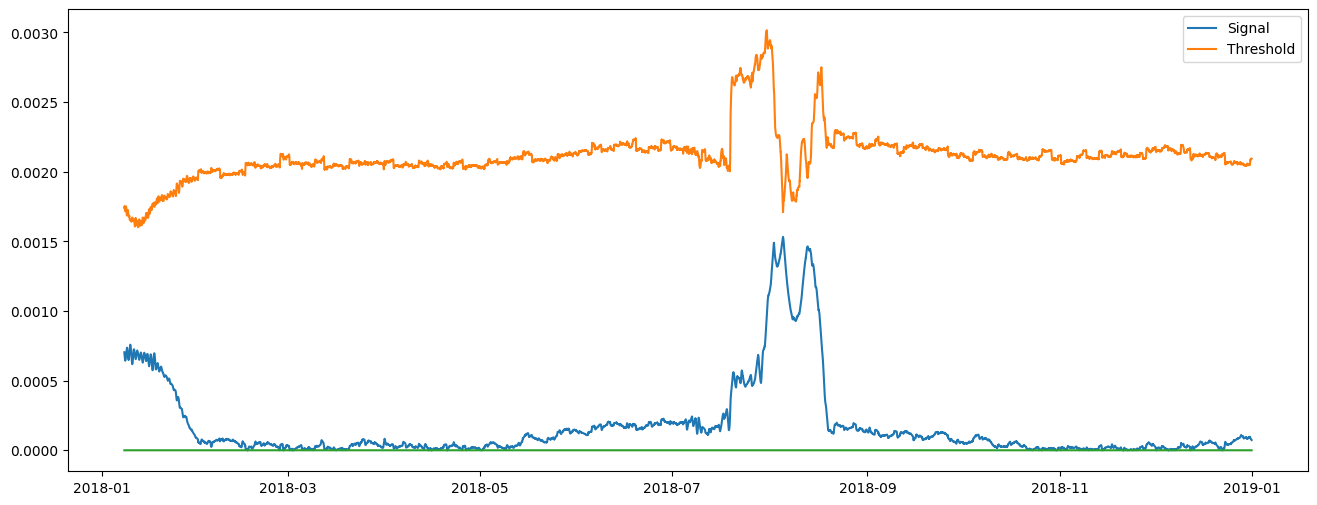

In [30]:
plotDetections('p31', filtered, r_m_k, threshold)